# Classification Models

## Table of contents:
* [Maximum Likelihood logistic regression](#maxlike)
* [Bayesian logistic regression](#bayesian)
* [Non-linear logistic regression](#non-linear)
* [Dual logistic regression](#dual)
* [Relevance vector classification](#relevant-vector)
* [Incremental fitting and boosting](#boosting)
* [Classification trees](#trees)
* [Multi-class logistic regression](#multiclass)
* [Random trees, forests, and ferns](#forest)
* [Multi-class logistic regression](#multiclass)

# Non-linear logistic regression

In the linear logistic regressions for 2-class classifications, we employed such bases, using $\mathbf{x} \leftarrow \big[1, \mathbf{x}^{T} \big]^{T}$ and $\mathbf{\phi} \leftarrow \big[\phi_{0},\mathbf{\phi}^{T} \big]^{T}$,

$$\begin{align}
p(w=1|\mathbf{x}, \mathbf{\phi}) \quad & = &\quad Bern_{w}\bigg[ sig\big[\mathbf{\phi}^{T}
\mathbf{x}\big]\bigg]\\
p(w=0|\mathbf{x}, \mathbf{\phi}) \quad & = &\quad 1 - Bern_{w}\bigg[ sig\big[\mathbf{\phi}^{T}
\mathbf{x}\big]\bigg]\\
sig\big[\mathbf{\phi}^{T}\mathbf{x}\big] \quad & = &\quad  \frac{1}{1 + exp(-\mathbf{\phi}^{T}\mathbf{x})}\\
Bern_{w}(\mathbf{a}) \quad & = &\quad \prod_{i}^{N} a_{i}^{w_{i}}(1 - a_{i})^{1 - w_{i}}
\end{align}$$

We extend the linear logistic regressions to employ non-linear bases.

$$\begin{align}
p(w=1|\mathbf{z}, \mathbf{\phi}) \quad & = &\quad Bern_{w}\bigg[ sig\big[\mathbf{\phi}^{T}
\mathbf{z}\big]\bigg]\\
p(w=0|\mathbf{z}, \mathbf{\phi}) \quad & = &\quad 1 - Bern_{w}\bigg[ sig\big[\mathbf{\phi}^{T}
\mathbf{z}\big]\bigg]\\
sig\big[\mathbf{\phi}^{T}\mathbf{z}\big] \quad & = &\quad  \frac{1}{1 + exp(-\mathbf{\phi}^{T}\mathbf{z})}
\end{align}$$

Here, for a choice of $K$ and $f$,

$$\begin{align}
\mathbf{z} \quad & = &\quad \big[1, f_{1}(\mathbf{x}), \cdots, f_{K}(\mathbf{x})\big]^{T}
\end{align}$$

Among the choice of $f$'s,

$$\begin{align}
z_{k} \quad & = &\quad heaviside[\mathbf{\alpha}_{k}^{T}\mathbf{x}] \quad & = &\quad 1 \quad if \quad \mathbf{\alpha}_{k}^{T}\mathbf{x} > 0 \quad and \quad 0 \quad otherwise\\
z_{k} \quad & = &\quad arctan[\mathbf{\alpha}_{k}^{T}\mathbf{x}] \quad & = &\quad \\
z_{k} \quad & = &\quad gaussian[\mathbf{\alpha}_{k}^{T}\mathbf{x}, \lambda] \quad & = &\quad exp\bigg(-\frac{(\mathbf{x} - \alpha_{k})^{T}(\mathbf{x} - \alpha_{k})}{2\lambda}\bigg)
\end{align}$$

We can choose the loglikelihood as the logistic cost function.

$$\begin{align}
\mathbf{\theta} \quad & = &\quad \big[\mathbf{\phi}^{T}, \mathbf{\alpha}_{1}^{T}, \cdots,  \mathbf{\alpha}_{K}^{T} \big]^{T}\\
L(\mathbf{\theta}) \quad & = &\quad log \bigg[Bern_{w}(\mathbf{a}) \bigg]\\
 \quad & = &\quad \sum_{i}^{N} w_{i}log(a_{i}) + (1 - w_{i})log(1 - a_{i}) \\
 \quad & = &\quad \sum_{i}^{N} w_{i}log\bigg(\frac{1}{1 + exp(-\mathbf{\phi}^{T}\mathbf{z_{i}})}\bigg) + (1 - w_{i})log \bigg( \frac{exp(-\mathbf{\phi}^{T}\mathbf{z_{i}})}{1 + exp(-\mathbf{\phi}^{T}\mathbf{z_{i}})} \bigg) \\
\end{align}$$

Let us write the following explicitly for the case of $z_{i, k} = gaussian[\mathbf{\alpha}_{k}^{T}\mathbf{x}_{i}, \lambda]$

$$\begin{align}
a_{i} \quad & = &\quad \mathbf{\phi}^{T}\mathbf{z_{i}} \\
\quad & = &\quad \sum_{k=0}^{K} \phi_{k}z_{i,k} \\
\quad & = &\quad \phi_{0} + \sum_{k=1}^{K} \phi_{k} exp\bigg(-\frac{1}{\lambda}(\mathbf{x}_{i} - \mathbf{\alpha}_{k})^{T}(\mathbf{x}_{i} - \mathbf{\alpha}_{k})\bigg)\\
\quad & = &\quad \phi_{0} + \sum_{k=1}^{K} \phi_{k} exp\bigg(-\frac{1}{\lambda}\sum_{d=1}^{D} ({x}_{i, d} - \alpha_{d, k})^{2}\bigg)
\end{align}$$

In order to minimize the cost function, one may employ Newton method. Namely, optimize $\mathbf{\theta}$


$$\begin{align}
\mathbf{\theta}_{t+1} \quad & = &\quad \mathbf{\theta}_{t} - \beta\bigg(\frac{\partial^{2} L(\mathbf{\theta}_{t})}{\partial\theta_{j}\theta_{j'}}\bigg)^{-1}\frac{\partial L(\mathbf{\theta}_{t})}{\partial\theta_{j}} 
\end{align}$$

,where

$$\begin{align}
\frac{\partial L(\mathbf{\theta})}{\partial\theta_{j}} \quad & = &\quad - \sum_{i}^{N} ( w_{i} - sig[a_{i}]) \frac{\partial a_{i}}{\partial\theta_{j}} \\
\frac{\partial^{2} L(\mathbf{\theta})}{\partial\theta_{j}\theta_{j'}} \quad & = &\quad - \sum_{i}^{N} sig[a_{i}]\big(sig[a_{i}] - 1\big) \frac{\partial a_{i}}{\partial\theta_{j}} \frac{\partial a_{i}}{\partial\theta_{j'}}^{T} - ( w_{i} - sig[a_{i}]) \frac{\partial^{2} a_{i}}{\partial\theta_{j}\partial\theta_{j'}}
\end{align}$$

Let us explicitly write down the following.

$$\begin{align}
\mathbf{\theta} \quad & = &\quad \big[\phi_{0}, \phi_{1}, \cdots, \phi_{K}, \alpha_{1, 1}, \cdots, \alpha_{D, 1}, \cdots, \alpha_{1, K}, \cdots, \alpha_{D, K} \big] \quad & : & (K+1 + KD) \times 1
\end{align}$$

Here, we may add $\alpha_{0, k} = 1 \quad k\in(1,\cdots,K)$ for notational consistency. However, they are constant and no optimization takes place. We may treat $\lambda$ separetely for simplicity.

$$\begin{align}
\frac{\partial a_{i}}{\partial\theta_{\phi}} \quad & \Rightarrow &\quad \frac{\partial a_{i}}{\partial\phi_{k}} \quad & = & \quad \frac{\partial \phi_{k}}{\partial\phi_{k}} z_{i, k} \quad & = & \quad z_{i,k} \quad \Rightarrow \quad _{(K+1) \times N} \\
\frac{\partial a_{i}}{\partial\theta_{\alpha}} \quad & \Rightarrow & \quad \frac{\partial a_{i}}{\partial\mathbf{\alpha}_{dk}} \quad & = & \quad \phi_{k} \frac{\partial z_{i, k}}{\partial\alpha_{dk}} \quad & = & \quad \phi_{k}\bigg[ \frac{z_{i, k}}{\lambda}(x_{i,d} - \alpha_{dk})\bigg] \quad \Rightarrow \quad _{DK \times N}\\
\frac{\partial^{2} a_{i}}{\partial\theta_{\phi}\partial\theta_{\phi}} \quad & \Rightarrow &\quad \frac{\partial^{2} a_{i}}{\partial\phi_{k}\partial\phi_{k'}} \quad & = & \quad \frac{\partial^{2} \phi_{k'}}{\partial\phi_{k}\partial\phi_{k'}} z_{i, k'} \quad & = & \quad 0 \quad \Rightarrow \quad _{(K+1) \times (K+1) \times N}\\
\frac{\partial^{2} a_{i}}{\partial\theta_{\alpha}\partial\theta_{\phi}} \quad & \Rightarrow &\quad \frac{\partial^{2} a_{i}}{\partial\mathbf{\alpha}_{k}\partial{\phi}_{k'}} \quad & = & \quad \frac{\partial \phi_{k'}}{\partial\phi_{k'}}\frac{\partial z_{i,k}}{\partial\alpha_{dk}} \quad & = & \quad \frac{z_{i, k}}{\lambda}(x_{i,d} - \alpha_{dk})\delta_{kk'} \quad \Rightarrow \quad   _{KD \times K \times N}\\
\frac{\partial^{2} a_{i}}{\partial\theta_{\alpha}\partial\theta_{\alpha}} \quad & \Rightarrow &\quad \frac{\partial^{2} a_{i}}{\partial\alpha_{dk}\partial\alpha_{d'k'}} \quad & = &\quad \phi_{k}\frac{\partial^{2} z_{i,k'}}{\partial\alpha_{d,k}\partial\alpha_{d'k'}} \quad & = &\quad \phi_{k}\bigg[ \frac{z_{i, k}}{\lambda}\bigg( \frac{(x_{i,d} - \alpha_{dk})(x_{i,d'} - \alpha_{d'k'})}{\lambda} - 1_{D\times D} \bigg) \bigg] \delta_{kk'} \quad \Rightarrow \quad  _{KD \times KD \times N}
\end{align}$$

In [374]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spsp
import scipy.stats as spst
%matplotlib inline

# usual gangs

In [738]:
def generate_data_set_dim1_nonlinear(ns):
    """
    this function generates a 1d data set of two classes which are linearly separated.
    
    Arguments:
        ns: number of samples
    
    Output:
        ds1   : data on the negative side (2, ns). ds1[1] = 0 is the label.
        ds2   : data on the positive side (2, ns). ds2[1] = 1 is the label.
        data  : data combined ds1 and ds2 and shuffled. (1, ns)
        label : label combined ds1 and ds2 and shuffled. (1, ns)
        datab : data combined ds1 and ds2 and shuffled. data1[0] = 1 for bias. (2, ns)
    """
    ns_neg1 = int(0.3 * ns)
    ns_neg2 = int(0.3 * ns)
    ns_neg  = ns_neg1 + ns_neg2
    ns_pos  = ns - ns_neg
    mus = [-6, 6, -0]
    
    dt_neg1 = np.random.standard_t(3, size=ns_neg1) + mus[0]
    dt_neg2 = np.random.standard_t(3, size=ns_neg2) + mus[1]
    ds1 = np.hstack((dt_neg1, dt_neg2))
    ds1 = np.vstack((ds1, np.zeros(ns_neg)))
    
    dt_pos = np.random.standard_t(3, size=ns_pos) + mus[2]
    ds2 = dt_pos
    ds2 = np.vstack((ds2, np.ones(ns_pos)))
    
    ds = np.hstack((ds1, ds2))
    np.random.shuffle(ds.T)
    data = ds[0][np.newaxis, :]
    label = ds[1][np.newaxis, :]
    
    datas, mu, sg = scale_coordinates(data)
    ds1s = (ds1[0] - mu)/sg
    ds2s = (ds2[0] - mu)/sg
    
    plt.plot(ds1s[0], ds1[1], 'r.', markersize=3)
    plt.plot(ds2s[0], ds2[1], 'b.', markersize=3)
    plt.xlim((-3, 3))
    plt.ylim((-0.1, 1.1))
    return ds1s, ds2s, datas, label


def generate_data_set_dim2_nonlinear(ns):
    """
    this function generates a 2d data set of two classes which are linearly separated.
    
    Arguments:
        ns: number of samples
    
    Output:
        ds1: data on the negative side (3, ns). ds1[1] = 0 is the label.
        ds2: data on the positive side (3, ns). ds2[1] = 0 is the label.
        data  : data combined ds1 and ds2 and shuffled. (2, ns)
        label : label combined ds1 and ds2 and shuffled. (2, ns)
        datab : data combined ds1 and ds2 and shuffled. datab[0] = 1 for bias. (3, ns)
    """
    ns_neg1 = int(0.25 * ns)
    ns_neg2 = int(0.25 * ns)
    ns_neg  = ns_neg1 + ns_neg2
    ns_pos1 = int(0.25 * ns)
    ns_pos2 = ns - ns_neg1 - ns_neg2 - ns_pos1
    ns_pos  = ns_pos1 + ns_pos2
    amp = 5.
    mus = amp * np.array([-1., 1., -1., 1.])
    
    dt_neg1 = np.random.standard_t(3, size=ns_neg1) + mus[0]
    dt_neg2 = np.random.standard_t(3, size=ns_neg2) + mus[1]
    ds1x = np.hstack((dt_neg1, dt_neg2))
    ds1y = 1.5 * amp * (np.random.rand(ns_neg) - .5)
    ds1 = np.vstack((ds1x, ds1y))
    
    dt_pos1 = np.random.standard_t(3, size=ns_pos1) + mus[2]
    dt_pos2 = np.random.standard_t(3, size=ns_pos2) + mus[3]
    ds2x = np.hstack((dt_pos1, dt_pos2))
    ds2y = 1.5 * amp * (np.random.rand(ns_pos) - .5)
    ds2 = np.vstack((ds2x, ds2y))
    
    ang = 0.25 * np.pi
    c, s = np.cos(ang), np.sin(ang)
    rot1 = np.array([[c, s], [-s, c]])
    
    ang = -ang
    c, s = np.cos(ang), np.sin(ang)
    rot2 = np.array([[c, s], [-s, c]])
    
    ds1 = np.dot(rot1, ds1)
    ds2 = np.dot(rot2, ds2)
    
    ds1s = np.vstack((ds1, np.zeros(ns_neg)))
    ds2s = np.vstack((ds2, np.ones(ns_pos)))
    ds = np.hstack((ds1s, ds2s))
    np.random.shuffle(ds.T)
    
    data = ds[:2]
    label = ds[2][np.newaxis, :]
    
    datas, mu, sg = scale_coordinates(data)
    ds1s = (ds1[:2] - mu)/sg
    ds2s = (ds2[:2] - mu)/sg
    
    plt.plot(ds1s[0], ds1s[1], 'r.', markersize=3)
    plt.plot(ds2s[0], ds2s[1], 'b.', markersize=3)
    plt.xlim((-3, 3))
    plt.ylim((-3, 3))
    return ds1s, ds2s, datas, label



In [918]:
def cost_function(z, w, phi):
    """
    this function computes logistic cost function
    
    Arguments:
        z   :  (K + 1, N)  1 is for bias.
        w   :  (1, N)
        phi :  (1, K + 1)
    
    Output:
        L:     scalar. cost function.
    """
    sig = sigmoid(z, phi)
    wlogsig1 = np.dot(w, np.log(sig))
    wlogsig2 = np.dot(1 - w, np.log(1 - sig))
    L = wlogsig1 + wlogsig2
    return L

    
def sigmoid(z, phi):
    """
    this function computes sigmoid function
    
    Arguments:
        z   :  (K + 1, N)  1 is for bias.
        phi :  (1, K + 1)
    
    Output:
        sig  :  (N, 1)
    """
    phix = np.dot(phi, z)
    denom = 1 + np.exp(-phix) 
    sig = 1 / denom
    return sig.T


def newton_method_update(z, x, w, phi, alp, beta, lmd):
    """
    this function computes sigmoid function
    
    Arguments:
        z    : generated bases including bias at the zeroth row. ((K+1) * N).
        x    : original cooridnates of the samples. (D, N)
        phi  : phi. (1, (K+1))
        alp  : alpha. (D, K)
        beta : scalar. learning rate.
        lmd  : scalar.
    
    Intermediate:
        dLdt   : ((K+1+KD), 1)
        ddLdtdt: ((K+1+KD), (K+1+KD))
        
    Output:
        theta: (1, (K+1+KD))
    """
    D = x.shape[0]
    K = alp.shape[1]
    K1 = z.shape[0]
    N = x.shape[1]
    theta = np.hstack((phi, alp.T.reshape(1, K*D)))
    dLdt    = dL_dtheta(z, x, w, phi, alp, lmd)
    ddLdtdt = ddL_dtheta_dtheta(z, x, w, phi, alp, lmd)
    ddLdtdt_inv = np.linalg.inv(ddLdtdt)
    theta -= beta * np.dot(ddLdtdt_inv, dLdt).T
    phi = theta[0, :K1].reshape(1, K1)
    alp = theta[0, K1:].reshape(K, D).T
    return phi, alp
    
    
def newton_method(z, x, w, phi, alp, beta, lmd, nnn):
    """
    this function computes sigmoid function
    
    Arguments:
        z    : generated bases including bias at the zeroth row. ((K+1), N).
        x    : original cooridnates of the samples. (D, N)
        phi  : phi. (1, (K+1))
        alp  : alpha. (D, K)
        beta : scalar. learning rate.
        lmd  : scalar.
        
    Output:
        theta: (1, (K+1+KD))
    """
    D = x.shape[0]
    K = alp.shape[1]
    K1 = z.shape[0]
    N = x.shape[1]
    dlt = 1
    step = 1
    Ls = np.zeros(nnn)
    cost = cost_function(z, w, phi)
    #while dlt > 0.001:
    while step < nnn:
        temp = cost
        z = radial_basis(x, alp, lmd)
        phi, alp = newton_method_update(z, x, w, phi, alp, beta/(step**0.5), lmd)
        #cost = cost_function(z, w, phi) 
        Ls[step] = cost
        dlt = np.abs(cost - temp)
        step += 1
        #if step == nnn:
        #    break
    theta = np.hstack((phi, alp.T.reshape(1, K*D)))
    param_description(step, theta.squeeze(), D, K, K1)
    cost = Ls[:step]
    return phi, alp, theta, cost, step


def param_description(step, theta, D, K, K1):
    strng = '{:d} steps done: '.format(step + 1)
    strng += '\nphi = \n'
    for i in range(K1):
        strng += '{:1.4f}, '.format(theta[i])
    strng += '\nalp = '
    for d in range(D):
        strng += '\n'
        for i in range(K1+d, K1+K*D, D):
            strng += '{:1.4f}, '.format(theta[i])
    print(strng)

In [740]:
def dz_dalp(x, z, alp, lmd):
    """
    this function generates dRB/dalp.
    
    Arguments:
        z  : generated bases including bias at the zeroth row. ((K+1) * N).
        x  : original cooridnates of the samples. (D, N)
        phi: phi. (1, (K+1))
        alp: alpha. (D, K)
        lmd: scalar.

    Output:
        dzdalp: ((KD), N)
    """
    return dRB_dalp(x, z, alp, lmd)


def ddz_dalp_dalp(x, z, alp, lmd):
    """
    this function generates dRB/dalp.
    
    Arguments:
        z  : generated bases including bias at the zeroth row. ((K+1) * N).
        x  : original cooridnates of the samples. (D, N)
        phi: phi. (1, (K+1))
        alp: alpha. (D, K)
        lmd: scalar.

    Output:
        ddz_dalp_dalp: (KD, KD, N)
    """
    return ddRB_dalp_dalp(x, z, alp, lmd)


def da_dphi(z):
    """
    this function generates da/dphi.
    
    Arguments:
        z: generated bases including bias at the zeroth row. ((K+1), N).
    
    Output:
        z: da/dphi. ((K+1), N)
    """
    return z


def da_dalp(z, x, phi, alp, lmd):
    """
    this function generates da/dalp.
    
    Arguments:
        z  : generated bases including bias at the zeroth row. ((K+1), N).
        x  : original cooridnates of the samples. (D, N)
        phi: phi. (1, (K+1))
        alp: alpha. (D, K)
        lmd: scalar.
    
    Intermediate:
        phit  : phi_trancated. without bias. (1, K)
        phix  : phi_extended.  (1, KD)
        dzda  : dzdalp. ((KD), N)
        xx    : (K*D, N)
        alpx  : (K*D, 1)

    Output:
        da/dalp: (K*D, N)
    """
    D = x.shape[0]
    K = alp.shape[1]
    K1 = phi.shape[1]
    N = x.shape[1]
    phit = phi[:, 1:]
    dzda = dz_dalp(x, z, alp, lmd)
    phix = np.kron(phit, np.ones((1, D)))
    dadalp = phix.T * dzda
    return dadalp


def da_dtheta(z, x, phi, alp, lmd):
    """
    this function generates da/dtheta.
    
    Arguments:
        z  : generated bases including bias at the zeroth row. ((K+1) * N).
        x  : original cooridnates of the samples. (D, N)
        phi: phi. (1, (K+1))
        alp: alpha. (D, K)
        lmd: scalar.

    Output:
        da/dtheta: ((K+1+KD), N)
    """
    D = x.shape[0]
    K = alp.shape[1]
    K1 = z.shape[0]
    N = x.shape[1]
    dadt = np.zeros((K1 + K*D, N))
    dadt[:K1, :] = da_dphi(z)
    dadt[K1:, :] = da_dalp(z, x, phi, alp, lmd)
    return dadt


def dda_dphi_dphi(z):
    """
    this function generates dda/dphidphi.
    
    Arguments:
        z  : generated bases including bias at the zeroth row. ((K+1) * N).

    Output:
        dda/dphidphi: ((K+1), (K+1), N)
    """
    K1 = z.shape[0]
    N  = z.shape[1]
    ddadphidphi = np.zeros((K1, K1, N))
    return ddadphidphi


def dda_dphi_dalp(z, x, phi, alp, lmd):
    """
    this function generates dda/dphidalp.
    
    Arguments:
        z  : generated bases including bias at the zeroth row. ((K+1) * N).
        x  : original cooridnates of the samples. (D, N)
        phi: phi. (1, (K+1))
        alp: alpha. (D, K)
        lmd: scalar.
    
    Intermediate:
        pf    : (K+1, N)
        pfx   : (K*D, N)
        xx    : (K*D, N)
        alpx  : (K*D, 1)
        dlt   : (K*D, N)

    Output:
        ddadphidalp: (KD, K, N)
    """
    D = x.shape[0]
    K = alp.shape[1]
    K1 = z.shape[0]
    N = x.shape[1]
    dzda = dz_dalp(x, z, alp, lmd)
    ddadphidalp = np.tile(dzda[:, np.newaxis, :], (1, K, 1))
    return ddadphidalp


def dda_dalp_dalp(z, x, phi, alp, lmd):
    """
    this function generates dda/dphidalp.
    
    Arguments:
        z  : generated bases including bias at the zeroth row. ((K+1) * N).
        x  : original cooridnates of the samples. (D, N)
        phi: phi. (1, (K+1))
        alp: alpha. (D, K)
        lmd: scalar.
    
    Intermediate:
        ddzdada : (KD, KD, N)

    Output:
        da/dtheta: (KD, KD, N)
    """
    D = x.shape[0]
    K = alp.shape[1]
    K1 = z.shape[0]
    N = x.shape[1]
    ddz_dada = ddz_dalp_dalp(x, z, alp, lmd)
    phit = phi[0, 1:]
    phitx = np.kron(np.diag(phit), np.ones((D, D)))[:, :, np.newaxis]
    dda_dada = phitx * ddz_dada
    return dda_dada


def dda_dtheta_dtheta(z, x, phi, alp, lmd):
    """
    this function generates dda/dphidalp.
    
    Arguments:
        z  : generated bases including bias at the zeroth row. ((K+1) * N).
        x  : original cooridnates of the samples. (D, N)
        phi: phi. (1, (K+1))
        alp: alpha. (D, K)
        lmd: scalar.

    Output:
        da/dtheta: ((K+1+KD), N)
    """
    D = x.shape[0]
    K = alp.shape[1]
    K1 = z.shape[0]
    N = x.shape[1]
    nn = K1 + K*D
    ddadtdt = np.zeros((nn, nn, N))
    ddadtdt[:K1, :K1, :] = dda_dphi_dphi(z)
    ddadpda = dda_dphi_dalp(z, x, phi, alp, lmd)
    ddadtdt[K1:, 1:K1, :] = ddadpda
    ddadtdt[1:K1, K1:, :] = np.swapaxes(ddadpda, 0, 1)
    ddadtdt[K1:, K1:,  :] = dda_dalp_dalp(z, x, phi, alp, lmd)
    return ddadtdt


def dL_dtheta(z, x, w, phi, alp, lmd):
    """
    this function generates dda/dphidalp.
    
    Arguments:
        z  : generated bases including bias at the zeroth row. ((K+1) * N).
        x  : original cooridnates of the samples. (D, N)
        w  : label. (1, N)
        phi: phi. (1, (K+1))
        alp: alpha. (D, K)
        lmd: scalar.
    
    Intermediate:
        sig   : (N, 1)
        dadt  : ((K+1+KD), N)
        dlt   : (1, N)

    Output:
        dLdt: ((K+1+KD), 1)
    """
    dadt = da_dtheta(z, x, phi, alp, lmd)
    sig = sigmoid(z, phi)
    dLdt = np.dot(dadt, w.T - sig)
    dLdt *= -1
    return dLdt


def ddL_dtheta_dtheta(z, x, w, phi, alp, lmd):
    """
    this function generates dda/dphidalp.
    
    Arguments:
        z  : generated bases including bias at the zeroth row. ((K+1) * N).
        x  : original cooridnates of the samples. (D, N)
        w  : label. (1, N)
        phi: phi. (1, (K+1))
        alp: alpha. (D, K)
        lmd: scalar.
    
    Intermediate:
        sig   : (N, 1)
        dadt  : ((K+1+KD), N)
        dlt   : (1, N)
        err   : (N, )

    Output:
        ddLdtdt: ((K+1+KD), (K+1+KD))
    """
    dadt = da_dtheta(z, x, phi, alp, lmd)
    dadts = dadt[np.newaxis, :, :] * dadt[:, np.newaxis, :]
    ddadtdt = dda_dtheta_dtheta(z, x, phi, alp, lmd)
    sig = sigmoid(z, phi)
    err = (w - sig.T).squeeze()
    sigder = (sig * (sig - 1)).squeeze()
    ddLdtdt = np.einsum('i,jki->jk', sigder, dadts)
    ddLdtdt -= np.einsum('i,jki->jk', err, ddadtdt)
    ddLdtdt *= -1
    return ddLdtdt


In [745]:
def radial_basis(x, alp, lmd):
    """
    this function computes sigmoid function
    
    Arguments:
        x:   (D, ns)  D contains bias as well.
        label:   (1, ns)
        phi  :   (1, D)
        alpha:   scalar
        sgp  :   scalar. prior sigma
    
    Output:
        bases: (D, nx).
    """
    assert alp.shape[0] == x.shape[0]
    N = x.shape[1]
    D = x.shape[0]
    K = alp.shape[1]
    bases = np.ones((K + 1, N))
    if D == 1:
        for i in range(1, K + 1):
            bases[i, :] = spst.norm.pdf(x, alp[:, i-1].squeeze(), np.sqrt(lmd))
    else:
        for i in range(1, K + 1):
            bases[i, :] = spst.multivariate_normal.pdf(x.T, mean=alp[:, i-1], cov=lmd*np.eye(D))
    return bases


def dRB_dalp(x, z, alp, lmd):
    """
    this function generates dRB/dalp.
    
    Arguments:
        z  : generated bases including bias at the zeroth row. ((K+1) * N).
        x  : original cooridnates of the samples. (D, N)
        phi: phi. (1, (K+1))
        alp: alpha. (D, K)
        lmd: scalar.

    Output:
        dzdalp: ((KD), N)
    """
    assert alp.shape[0] == x.shape[0]
    K = alp.shape[1]
    N = x.shape[1]
    D = x.shape[0]
    xx = np.tile(x, (K, 1))
    alpx = np.reshape(alp.T, (K*D, 1))
    zx = np.kron(z[1:], np.ones((D, 1)))
    dzdalp = (xx - alpx) * zx / lmd
    return dzdalp


def ddRB_dalp_dalp(x, z, alp, lmd):
    """
    this function generates dda/dphidalp.
    
    Arguments:
        z  : generated bases including bias at the zeroth row. ((K+1) * N).
        x  : original cooridnates of the samples. (D, N)
        phi: phi. (1, (K+1))
        alp: alpha. (D, K)
        lmd: scalar.
    
    Intermediate:
        pf    : (K+1, N)
        pfx   : (K*D, N)
        xx    : (K*D, N)
        alpx  : (K*D, 1)
        dlt   : (K*D, N)

    Output:
        ddRBdada: (KD, KD, N)
    """
    D = x.shape[0]
    K = alp.shape[1]
    N = x.shape[1]
    xx = np.tile(x[:, np.newaxis, :], (1, K, 1))
    alpx = alp[:, :, np.newaxis]
    dlt = xx - alpx
    dltx = dlt[np.newaxis, :, :, :]
    dltxT = dlt[:, np.newaxis, :, :]
    pare = (dltxT * dltx) / lmd - np.eye(D)[:, :, np.newaxis,  np.newaxis]
    ddRBdada = np.zeros((K*D, K*D, N))
    for k in range(K):
        ddRBdada[D*k:D*(k+1), D*k:D*(k+1), :] = z[k, :] * pare[:, :, k, :] / lmd
    return ddRBdada



In [742]:

def plot_decision_boundary_dim1(phi, alp, lmd):
    """
    this function computes sigmoid function
    
    Arguments:
        phi  : phi. (1, (K+1))
        alp  : alpha. (D, K)
        beta : scalar. learning rate.
        lmd  : scalar.
    
    Intermediate:
        dLdt   : ((K+1+KD), 1)
        ddLdtdt: ((K+1+KD), (K+1+KD))
        
    Output:
        theta: (1, (K+1+KD))
    """
    D = alp.shape[0]
    K = alp.shape[1]
    K1 = phi.shape[1]
    N = 201
    x = np.linspace(-10, 10, N)
    z = np.ones((K1, N))
    for i in range(1, K1):
        z[i, :] = spst.norm.pdf(x, alp[:, i-1].squeeze(), lmd)
    dbdr = sigmoid(z, phi)
    return x, dbdr


def plot_decision_boundary_dim2(phi, alp, lmd):
    """
    this function computes sigmoid function
    
    Arguments:
        phi  : phi. (1, (K+1))
        alp  : alpha. (D, K)
        beta : scalar. learning rate.
        lmd  : scalar.
    
    Intermediate:
        dLdt   : ((K+1+KD), 1)
        ddLdtdt: ((K+1+KD), (K+1+KD))
        
    Output:
        theta: (1, (K+1+KD))
    """
    D = alp.shape[0]
    K = alp.shape[1]
    K1 = phi.shape[1]
    N = 201
    nn = N**2
    x = np.linspace(-3, 3, N)
    y = np.linspace(-3, 3, N)
    xg, yg = np.meshgrid(x, y)
    xss = xg.reshape(1, nn)
    yss = yg.reshape(1, nn)
    xys = np.vstack((xss, yss))
    z = radial_basis(xys, alp, lmd)
    bd = sigmoid(z, phi).reshape(N, N)
    bd = np.flipud(bd)
    plt.imshow(bd, extent=[-3, 3, -3, 3])
    return bd


def scale_coordinates(x):
    mu = x.mean(keepdims=1)
    sg = x.std()
    xs = (x - mu)/sg
    return xs, mu, sg

10001 steps done: 
phi = 
-0.5499, -2.4576, 1.7290, -4.5613, 5.2219, 
alp = 
0.9169, -0.6729, -0.9019, -0.1037, 


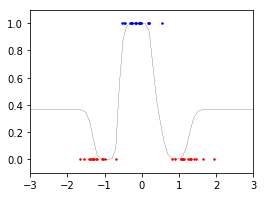

In [947]:
D = 1
K = 4
N = 50
nnn = 10000
beta = 0.01
lmd = 0.2
phi = 2 * (np.random.rand(1, K + 1) - 0.5)
alp = 2 * (np.random.rand(D, K) - 0.5)

plt.rcParams['figure.figsize'] = (4.0, 3.0)

_, _, x, w = generate_data_set_dim1_nonlinear(N)
z = radial_basis(x, alp, lmd)
phi, alp, theta, cost, step = newton_method(z, x, w, phi, alp, beta, lmd, nnn)
xdb, dbdr = plot_decision_boundary_dim1(phi, alp, lmd)
plt.plot(xdb.squeeze(), dbdr.squeeze(), '-', markersize=3, color=(0., 0., 0.), lw = 0.2)

#plt.subplot(1, 2, 2)
#plt.plot(np.arange(step), cost, '.')

Gaussians are not appropriate for the 1D problems above as every gaussian decays away from its center. Using Arctan would be better. stupid....

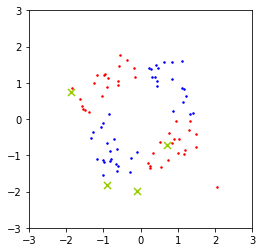

In [967]:
D = 2
K = 4
N = 80
nnn = 20000
beta = 0.05
lmd = 0.5
phi = 2 * 2 * (np.random.rand(1, K + 1) - 0.5)
alp = 2 * 2 * (np.random.rand(D, K) - 0.5)

plt.rcParams['figure.figsize'] = (4.0, 4.0)
ds1, ds2, x, w = generate_data_set_dim2_nonlinear(N)
plt.scatter(alp[0], alp[1], s=50, c=(0.6, 0.8, 0.), marker='x')

20001 steps done: 
phi = 
20.4127, 45.5204, 2227.3401, -366.0871, -1815.4812, 
alp = 
0.7749, -0.7472, -1.2730, 0.8517, 
-0.6101, -1.4523, 1.0111, -1.6364, 


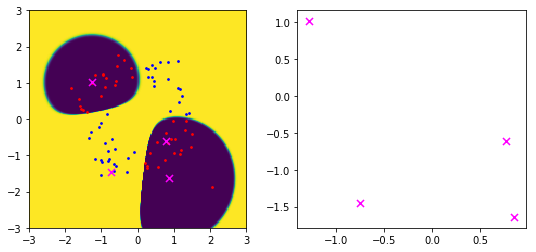

In [968]:
plt.rcParams['figure.figsize'] = (9.0, 4.0)
z = radial_basis(x, alp, lmd)
phi, alp, theta, cost, step = newton_method(z, x, w, phi, alp, beta, lmd, nnn)

plt.subplot(1,2,1)
bd = plot_decision_boundary_dim2(phi, alp, lmd)
plt.scatter(ds1[0], ds1[1], c=(1., 0., 0.), s=3)
plt.scatter(ds2[0], ds2[1], c=(0., 0., 1.), s=3)
plt.scatter(alp[0], alp[1], s=50, c=(1.0, 0.0, 1.0), marker='x')
plt.xlim((-3, 3))
plt.ylim((-3, 3))

plt.subplot(1,2,2)
plt.scatter(alp[0], alp[1], s=50, c=(1.0, 0.0, 1.0), marker='x')

### the below is just a part of experimentations to make the functions work and find out which ways would be faster..

In [ ]:
x = np.linspace(-10, 10, 201)[np.newaxis, :]
D = 1
K = 4
lmd = 1
z = radial_basis(x.squeeze(), K, lmd)
phi = np.random.rand(1, K + 1)
alp = np.random.rand(D, K)

In [ ]:
print('x:', x.shape)
print('alpha:', alp.shape)
print('phi:', phi.shape)
print('z:', z.shape)
pf = np.einsum('ij,ik', phi, z)/lmd
print('pf:', pf.shape)
pf_ex = np.kron(pf[1:], np.ones((D, 1)))
print('pf_ex:', pf_ex.shape)
x_ex = np.tile(x, (alp.shape[1], 1))
print('x_ex:', x_ex.shape)
alp_ex = alp.reshape(D*K, 1)
print('alp_ex:', alp_ex.shape)
da_dalp = pf[1:] * (x_ex - alp_ex)
print('da_dalp:', da_dalp.shape)
da_dphi = z
print('da_dphi:', da_dphi.shape)
da_dtheta = np.vstack((da_dphi, da_dalp))
print('da_dtheta:', da_dtheta.shape)
pf = phi.T * z / lmd
print('pf: ', pf.shape)
xx = np.tile(x[:, np.newaxis, :], (1, K, 1))
print('xx: ', xx.shape)
alpx = np.tile(alp[:, :, np.newaxis], (D, 1, 1))
print('alpx: ', alpx.shape)
dlt = xx - alpx
print('dlt: ', dlt.shape)
dltx = dlt[np.newaxis, :, :, :]
print('dltx: ', dltx.shape)
dltxT = dlt[:, np.newaxis, :, :]
print('dltxT: ', dltxT.shape)
dltxs = (dltxT * dltx) / lmd
print('dltxs: ', dltxs.shape)
ones = np.eye(D)[:, :, np.newaxis,  np.newaxis]
print('ones: ', ones.shape)

In [ ]:
K1 = z.shape[0]
N = z.shape[1]
dda_dphidphi = np.zeros((K1, K1, N))
dda_dphidphi.shape
kk = np.concatenate((dxda_dphidphi, dda_dphidphi), axis=0)
np.swapaxes(kk,0,1).shape

In [ ]:
tl = dd_a_d_phi_d_phi
bl = dda_dphidalp
tr = np.swapaxes(dda_dphidalp, 0, 1)
tr_bl = np.concatenate((tl, bl), axis=0)

print('top_left:', tl.shape)
print('bot_left:', bl.shape)
print('top_rght:', tr.shape)
print('tr_bl   :', tr_bl.shape)

In [ ]:
import time

a = 20
b = 60
c = 100

now = time.time()
dd1 = np.random.rand(1, a, b, c)
temp = time.time()
print('dd1: ', dd1.shape, ' in ', temp - now)
dd2 = np.swapaxes(dd1, 0, 1)
print('dd2: ', dd2.shape)
dd3 = dd1 * dd2
print('dd3: ', dd3.shape)
dd4 = np.reshape(dd3, (a, a*b, c))
print('dd4: ', dd4.shape)
dd5 = np.tile(dd4, (b, 1, 1))
print('dd5: ', dd5.shape)
flt = np.tile(np.kron(np.eye(b), np.ones((a, a)))[:, :, np.newaxis], (1, 1, c))
print('flt: ', flt.shape)
dd6 = flt * dd5
print('dd6: ', dd6.shape)x

In [ ]:
import time

a = 20
b = 60
c = 100

now = time.time()
dd1 = np.random.rand(1, a, b, c)
dd2 = np.swapaxes(dd1, 0, 1)
dd3 = dd1 * dd2
dd4 = np.reshape(dd3, (a, a*b, c))
dd5 = np.tile(dd4, (b, 1, 1))
flt = np.tile(np.kron(np.eye(b), np.ones((a, a)))[:, :, np.newaxis], (1, 1, c))
dd6 = flt * dd5
temp = time.time()
print('in ', temp - now)


now = time.time()
dd1 = np.random.rand(1, a, b, c)
dd2 = np.swapaxes(dd1, 0, 1)
dd3 = dd1 * dd2
rst = np.zeros((a*b, a*b, c))
for i in range(b):
    rst[a*i:a*(i+1), a*i:a*(i+1), :] = dd3[:, :, i, :]
temp = time.time()
print('in ', temp - now)

np.array_equal(rst, dd6)

In [ ]:
now = time.time()
ddd3 = np.concatenate((dd3, dd3), axis=2)
temp = time.time()
print(temp - now)

now = time.time()
aaa = np.zeros((dd3.shape[0], dd3.shape[1], 2*dd3.shape[2], dd3.shape[3]))
aaa[:, :, :dd3.shape[2], :] = dd3
aaa[:, :, dd3.shape[2]:, :] = dd3
temp = time.time()
print(temp - now)

In [352]:
assert alp.shape[0] == x.shape[0]
K = alp.shape[1]
N = x.shape[1]
D = x.shape[0]
xx = np.tile(x, (K, 1))
alpx = np.reshape(alp.T, (K*D, 1))

In [553]:
a = np.arange(1,11)
aa = a.reshape(2,5)
aaa = np.kron(aa, np.ones((3, 1)))
aaa[1:]

array([[  1.,   2.,   3.,   4.,   5.],
       [  1.,   2.,   3.,   4.,   5.],
       [  6.,   7.,   8.,   9.,  10.],
       [  6.,   7.,   8.,   9.,  10.],
       [  6.,   7.,   8.,   9.,  10.]])

In [391]:
D = x.shape[0]
K = alp.shape[1]
K1 = z.shape[0]
N = x.shape[1]
xx = np.tile(x[:, np.newaxis, :], (1, K, 1))
alpx = alp[:, :, np.newaxis]
dlt = xx - alpx
dltx = dlt[np.newaxis, :, :, :]
dltxT = dlt[:, np.newaxis, :, :]
pare = (dltxT * dltx) / lmd
pare -= np.eye(D)[:, :, np.newaxis,  np.newaxis]
dda_dada = np.zeros((K*D, K*D, N))
for k in range(K):
    dda_dada[D*k:D*(k+1), D*k:D*(k+1), :] = phi[0, k] * z[k, :] * pare[:, :, k, :] / lmd

In [ ]:
def newton_method(z, x, w, phi, alp, beta, lmd):
    """
    this function computes sigmoid function
    
    Arguments:
        z    : generated bases including bias at the zeroth row. ((K+1) * N).
        x    : original cooridnates of the samples. (D, N)
        phi  : phi. (1, (K+1))
        alp  : alpha. (D, K)
        beta : scalar. learning rate.
        lmd  : scalar.
        
    Output:
        theta: (1, (K+1+KD))
    """
    D = x.shape[0]
    K = alp.shape[1]
    K1 = z.shape[0]
    N = x.shape[1]
    dlt = 1
    step = 0
    nnn = 100000
    #thetas = np.zeros((10000, nn))
    theta = np.hstack((phi, alp.T.reshape(1, K*D)))
    #thetas[step, :] = theta
    Ls = np.zeros(nnn)
    cost = cost_function(z, w, phi)
    while dlt > 0.00001:
        #temp = copy.deepcopy(theta)
        temp = cost
        z = radial_basis(x, alp, lmd)
        phi, alp = newton_method_update(z, x, w, phi, alp, beta, lmd)
        cost = cost_function(z, w, phi) 
        Ls[step] = cost
        dlt = np.abs((cost - temp)/cost)
        #theta = np.hstack((phi, alp.T.reshape(1, K*D)))
        #thetas[step, :] = theta
        #dlt = np.max(np.abs(temp - theta)/np.abs(temp))
        step += 1
        if step == nnn:
            break
    strng = '{:d} steps done: '.format(step + 1)
    strng += '\nphi = '
    for i in range(K1):
        strng += '{:1.4f}, '.format(theta.squeeze()[i])
    strng += '\nalp = '
    for i in range(K1, K1+K*D):
        strng += '{:1.4f}, '.format(theta.squeeze()[i])
    print(strng)
    #thetas = thetas[:(step + 1), :]
    cost = Ls[:step]
    phi = theta[0, :K1].reshape(1, K1)
    alp = theta[0, K1:].reshape(K, D).T
    return phi, alp, theta, cost, step



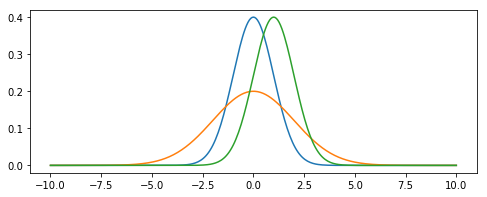

In [702]:
x=np.linspace(-10, 10, 301)
f1 = spst.norm.pdf(x, loc=0, scale=1)
f2 = spst.norm.pdf(x, loc=0, scale=2)
f3 = spst.norm.pdf(x, loc=1, scale=1)
plt.plot(x,f1)
plt.plot(x,f2)
plt.plot(x,f3)